In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations (standard normalization for ImageNet pre-trained models)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = "/media/mohan/mohan/Deep-Learning-with-PyTorch/Birds_25/train/"
val_data_path = "/media/mohan/mohan/Deep-Learning-with-PyTorch/Birds_25/valid/"

# Load dataset using ImageFolder
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)
val_data = datasets.ImageFolder(root=val_data_path, transform=transform)

# Create DataLoaders
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_data_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Check dataset size
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

Train samples: 30000
Validation samples: 7500


In [83]:
# Define a simple CNN instead of Fully Connected model
class ConvNet(nn.Module):
    def __init__(self, num_classes=25):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjusted according to pooling
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, start_dim=1)  # Flatten before FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No Softmax, as CrossEntropyLoss does it
        return x

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [101]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device="cuda"):
    model.to(device)
    
    # Lists to store metrics for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_acc = 0.0  # Store best accuracy
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        valid_loss = 0.0
        num_correct_train = 0
        num_examples_train = 0
        num_correct_val = 0
        num_examples_val = 0

        # Training Loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            num_correct_train += torch.sum(predictions == targets).item()
            num_examples_train += targets.shape[0]

        training_loss /= len(train_loader)
        train_accuracy = num_correct_train / num_examples_train * 100
        train_losses.append(training_loss)
        train_accuracies.append(train_accuracy)

        # Validation Loop
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = loss_fn(output, targets)
                valid_loss += loss.item()
                
                predictions = torch.argmax(output, dim=1)
                num_correct_val += torch.sum(predictions == targets).item()
                num_examples_val += targets.shape[0]

                # Store predictions and actual labels for confusion matrix
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        valid_loss /= len(val_loader)
        val_accuracy = num_correct_val / num_examples_val * 100
        val_losses.append(valid_loss)
        val_accuracies.append(val_accuracy)

        # Save best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

        scheduler.step()

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {training_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {valid_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    print(f"Best Validation Accuracy: {best_acc:.2f}%")
    
    # Return all metrics
    return train_losses, val_losses, train_accuracies, val_accuracies


In [102]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = ConvNet(num_classes=25).to(device)


optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


# Train the model and get loss & accuracy values
train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, loss_fn, train_data_loader, val_data_loader, epochs=5, device=device)

Epoch 1: Train Loss: 3.1830, Train Acc: 12.44%, Val Loss: 2.5175, Val Acc: 18.76%
Epoch 2: Train Loss: 2.2735, Train Acc: 25.89%, Val Loss: 2.0415, Val Acc: 33.99%
Epoch 3: Train Loss: 1.8417, Train Acc: 39.89%, Val Loss: 1.7817, Val Acc: 42.03%
Epoch 4: Train Loss: 1.5067, Train Acc: 50.84%, Val Loss: 1.6717, Val Acc: 48.07%
Epoch 5: Train Loss: 1.2459, Train Acc: 59.53%, Val Loss: 1.4263, Val Acc: 55.77%
Best Validation Accuracy: 55.77%


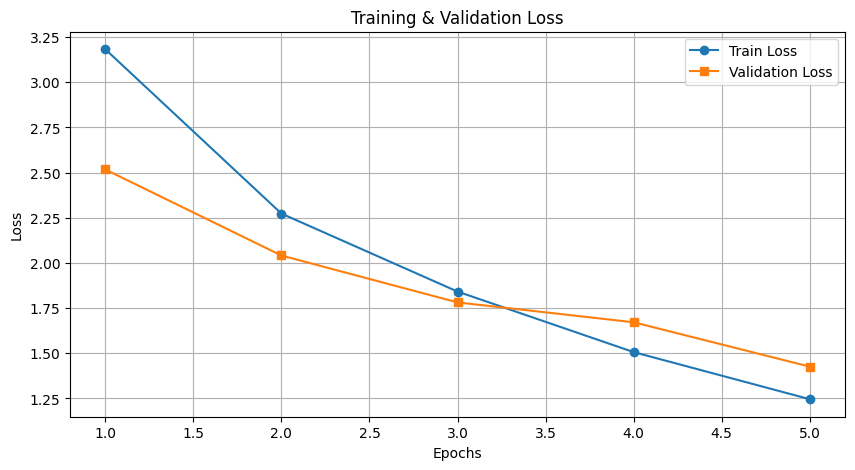

In [103]:
# Ensure losses exist before plotting
if len(train_losses) > 0 and len(val_losses) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Error: No loss data recorded. Check if losses are being appended during training.")


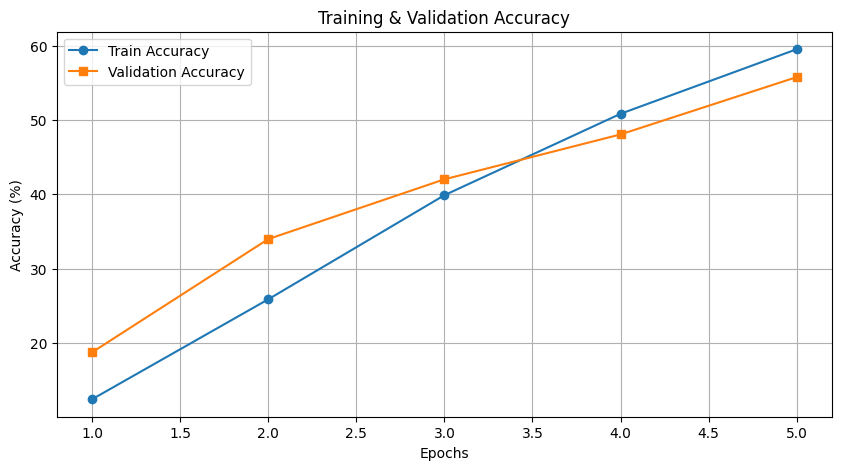

In [104]:
# Ensure accuracy values exist before plotting
if len(train_accuracies) > 0 and len(val_accuracies) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Error: No accuracy data recorded. Check if accuracies are being appended during training.")


In [105]:
from PIL import Image
# Define model architecture (same as during training)
model = ConvNet(num_classes=25)  

# Load trained weights
model.load_state_dict(torch.load("/media/mohan/mohan/Deep-Learning-with-PyTorch/best_model.pth"))

# Set model to evaluation mode
model.eval()


/tmp/ipykernel_8338/2073145420.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/media/mohan/mohan/Deep-Learning-with-PyTorch/best_model

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=25, bias=True)
)

In [114]:
# Send the image to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the same transformations used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization
])

# Load an image
image_path = "/media/mohan/mohan/Deep-Learning-with-PyTorch/Birds_25/valid/Indian-Peacock/Indian-Peacock_40.jpg"  
image = Image.open(image_path).convert("RGB")  # Ensure it's RGB

# Apply transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

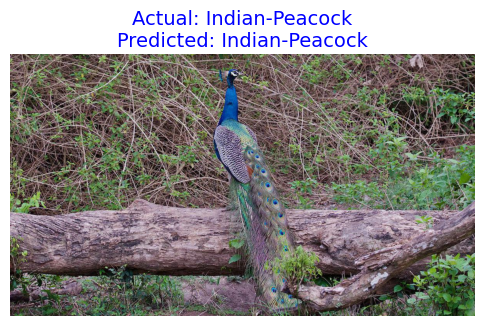

Predicted Class: Indian-Peacock


In [115]:
# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Perform inference
with torch.no_grad():
    output = model(image_tensor)

# Get predicted class index
predicted_class = torch.argmax(output, dim=1).item()

# Get class names (assuming dataset class indices are available)
class_names = train_data.classes  


actual_class_name = "Indian-Peacock"  # If you don't know the actual class
predicted_class_name = class_names[predicted_class]

# Display image 
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Actual: {actual_class_name}\nPredicted: {predicted_class_name}", fontsize=14, color="blue")
plt.show()


print(f"Predicted Class: {predicted_class_name}")
